# Baseline models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First let's load the data and perform a train-test split:

In [2]:
d = pd.read_csv('../preprocessing/bike_weather_daily.csv', parse_dates = ['Date'])

In [3]:
from sklearn.model_selection import train_test_split

d_train, d_test = train_test_split(d.copy(), test_size=0.2, random_state=49, shuffle=True)

Our response variable will be `num_trips`.  

## 1.  kNN regression

The data appears to be seasonal, following a clear annual pattern.  As a first baseline, we could implement a kNN model that predicts `num_trips` using only the day of the year. (January 1 is day 1 and December 31 is day 365.)

In [4]:
# Add column for day of the year
d_train['DoY'] = d_train['Date'].apply(lambda x : x.day_of_year)
d_test['DoY'] = d_test['Date'].apply(lambda x : x.day_of_year)

In [5]:
# Define 'distance' to be used in kNN
def dist(x,y):
    return min([abs(x-y),365-abs(x-y)])

Let's start with $k=5$ as an example:

In [6]:
# Build kNN model with k=5

from sklearn.neighbors import KNeighborsRegressor

model1 = KNeighborsRegressor(n_neighbors=5, metric=dist)
model1.fit(X=d_train[['DoY']], y=d_train[['num_trips']]);

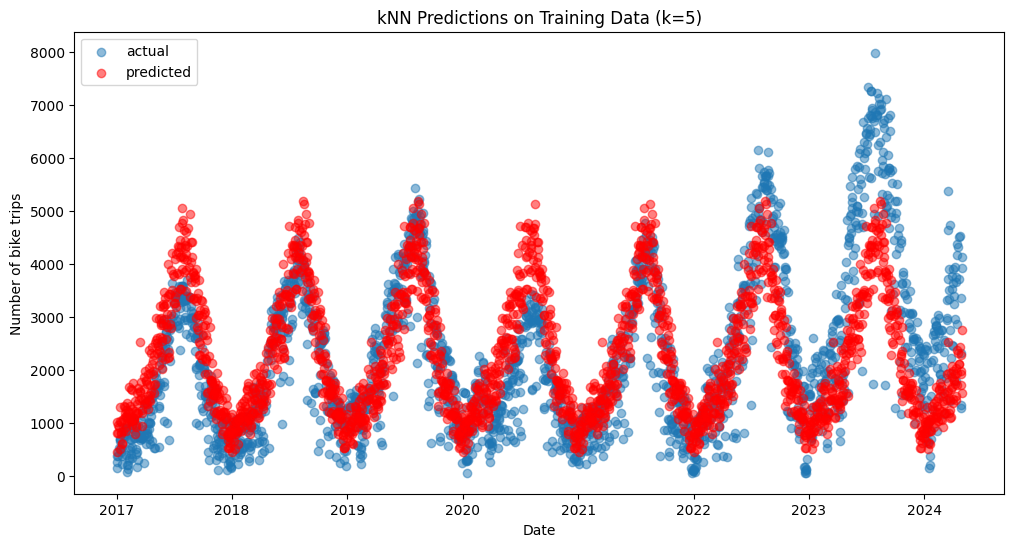

In [7]:
# Plot predictions on training data

y_train_pred = model1.predict(X=d_train[['DoY']])

ax = plt.subplots(figsize=(12,6))[1]
ax.scatter(d_train['Date'], d_train['num_trips'], alpha=0.5, label='actual')
ax.scatter(d_train['Date'], y_train_pred, alpha=0.5, c='r', label='predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Number of bike trips')
ax.legend(loc='upper left')
ax.set_title('kNN Predictions on Training Data (k=5)')
plt.show()

Now let's cross-validate to find the (approximate) optimal value of $k$:

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold = KFold(n_splits=5, random_state=50, shuffle=True)

k_vals = [j for j in range(1,10)] + [10*j for j in range(1,10)] + [50*j for j in range(2,21)] 

i=0
MSE_train = np.zeros((5,len(k_vals)))
MSE_test = np.zeros((5,len(k_vals)))

for train_index, test_index in kfold.split(d_train):

    CV_train = d_train.iloc[train_index]
    CV_test = d_train.iloc[test_index]

    for j in range(len(k_vals)):
        model = KNeighborsRegressor(n_neighbors=k_vals[j], metric=dist)
        model.fit(X=CV_train[['DoY']], y=CV_train[['num_trips']])

        pred_train = model.predict(X=CV_train[['DoY']])
        MSE_train[i,j] = mean_squared_error(y_true=CV_train[['num_trips']], y_pred=pred_train)

        pred_test = model.predict(X=CV_test[['DoY']])
        MSE_test[i,j] = mean_squared_error(y_true=CV_test[['num_trips']], y_pred=pred_test)

    i += 1

In [9]:
average_MSE_train= MSE_train.mean(axis=0)
average_MSE_test = MSE_test.mean(axis=0)

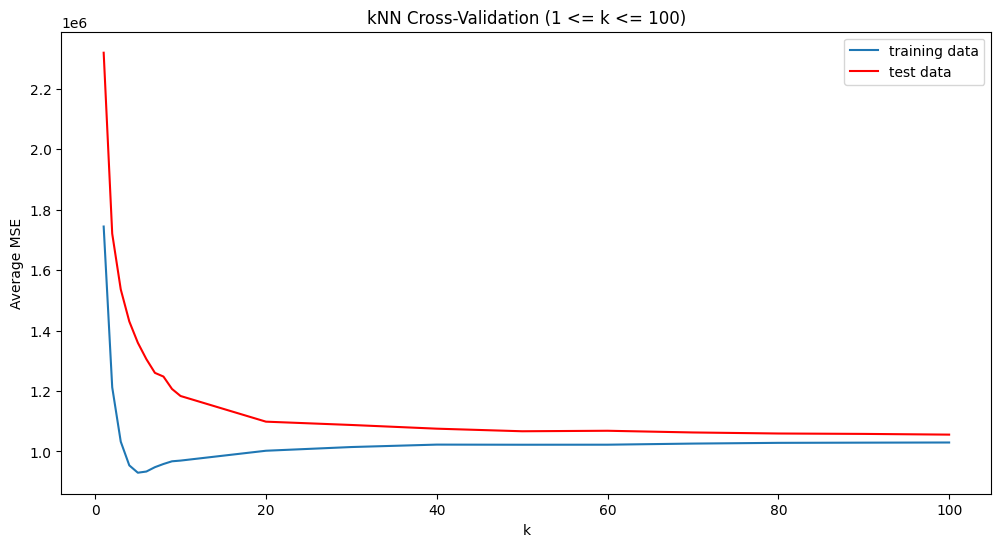

In [10]:
ax = plt.subplots(figsize=(12,6))[1]
ax.plot(k_vals[:19], average_MSE_train[:19], label='training data')
ax.plot(k_vals[:19], average_MSE_test[:19], c='r', label='test data')
ax.set_xlabel('k')
ax.set_ylabel('Average MSE')
ax.set_title('kNN Cross-Validation (1 <= k <= 100)')
ax.legend(loc='upper right')
plt.show()

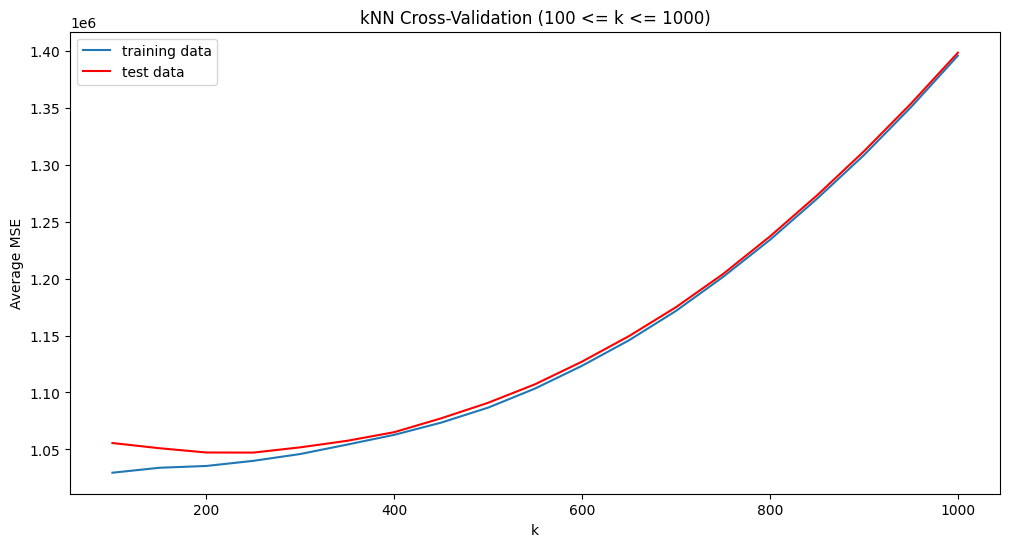

In [11]:
ax = plt.subplots(figsize=(12,6))[1]
ax.plot(k_vals[18:], average_MSE_train[18:], label='training data')
ax.plot(k_vals[18:], average_MSE_test[18:], c='r', label='test data')
ax.set_xlabel('k')
ax.set_ylabel('Average MSE')
ax.set_title('kNN Cross-Validation (100 <= k <= 1000)')
ax.legend(loc='upper left')
plt.show()

In [12]:
best_MSE = average_MSE_test.min()
best_k = k_vals[average_MSE_test.argmin()]

print('Best test MSE is', best_MSE, 'with k =', best_k)

Best test MSE is 1047254.6711972642 with k = 250


This suggests that a kNN model will perform best on our test data if $k \approx 250$.  (To get a more precise estimate on $k$, we could rerun the cross-validation using only values that are close to 250.)

## 2. Periodic or trigonometric regression